In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
oxide_data = {
    'SiO2': {'mw': 60.083, 'cations': 1, 'oxygens': 2},
    'Al2O3': {'mw': 101.961, 'cations': 2, 'oxygens': 3},
    'FeO': {'mw': 71.844, 'cations': 1, 'oxygens': 1},
    'MnO': {'mw': 70.937, 'cations': 1, 'oxygens': 1},
    'MgO': {'mw': 40.304, 'cations': 1, 'oxygens': 1},
    'CaO': {'mw': 56.077, 'cations': 1, 'oxygens': 1},
    'Na2O': {'mw': 61.979, 'cations': 2, 'oxygens': 1},
    'K2O': {'mw': 94.196, 'cations': 2, 'oxygens': 1},
}


In [9]:
def oxide_df_to_cation_dict(df, oxy_norm):
    results = {'rim':{}, 'middle':{}, 'core':{}}
    oxy_tot = {'rim':0, 'middle':0, 'core':0}

    for _, row in df.iterrows():
        ox = row['Oxide']
        if ox not in oxide_data:
            continue
        
        mw = oxide_data[ox]['mw']
        c = oxide_data[ox]['cations']
        o = oxide_data[ox]['oxygens']

        # map oxide → element
        if ox == 'SiO2': elt = 'Si'
        elif ox == 'Al2O3': elt = 'Al'
        elif ox == 'FeO': elt = 'Fe'
        elif ox == 'MnO': elt = 'Mn'
        elif ox == 'MgO': elt = 'Mg'
        elif ox == 'CaO': elt = 'Ca'
        elif ox == 'Na2O': elt = 'Na'
        elif ox == 'K2O': elt = 'K'

        for zone in ['rim','middle','core']:
            wt = float(row[zone])
            mol_ox = wt / mw
            oxy_tot[zone] += mol_ox * o
            
            results[zone].setdefault(elt, 0)
            results[zone][elt] += mol_ox * c

    # normalize
    for zone in ['rim','middle','core']:
        factor = oxy_norm / oxy_tot[zone]
        for elt in results[zone]:
            results[zone][elt] *= factor

    return results


In [24]:
oxide_list = ['SiO2','Al2O3','FeO','MnO','MgO','CaO','Na2O','K2O']

garnet = pd.DataFrame({
    'Oxide': oxide_list,
    'rim':    [36.85,21.76,33.17, 1.15,3.95,2.48,0.00,0.00],
    'middle': [37.46,21.69,28.13, 5.68,2.39,4.34,0.00,0.00],
    'core':   [37.38,21.72,26.11, 7.25,1.84,4.77,0.00,0.00]
})

biotite = pd.DataFrame({
    'Oxide': oxide_list,
    'rim':    [37.65,16.57,19.28,0.00,12.46,0.00,0.09,8.49],
    'middle': [36.00,18.86,20.57,0.06,10.14,0.00,0.00,8.78],
    'core':   [35.33,18.76,21.90,0.00, 9.62,0.00,0.00,8.44]
})

plagioclase = pd.DataFrame({
    'Oxide': oxide_list,
    'rim':    [58.79,26.70,0.0,0.0,0.0,7.89,7.23,0.12],
    'middle': [59.69,25.92,0.0,0.0,0.0,6.97,7.45,0.09],
    'core':   [61.55,24.41,0.0,0.0,0.0,5.19,8.41,0.28]
})

In [25]:
def oxide_to_cations(df, oxy_norm=None):
    
    results = {'rim': {}, 'middle': {}, 'core': {}}
    cation_moles = {}
    oxygen_moles = {}

    for _, row in df.iterrows():
        oxide = row['Oxide']
        if oxide not in oxide_data: 
            continue

        mw = oxide_data[oxide]['mw']
        c = oxide_data[oxide]['cation']
        o = oxide_data[oxide]['oxygen']

        for col in df.columns[1:]:
            wt = row[col]
            mol = wt / mw
            cation_moles.setdefault(col, 0)
            oxygen_moles.setdefault(col, 0)

            cation_moles[col] += mol * c
            oxygen_moles[col] += mol * o

    if oxy_norm:
        factor = oxy_norm / np.array(list(oxygen_moles.values()))
        factor = dict(zip(oxygen_moles.keys(), factor))
        for k in cation_moles:
            cation_moles[k] *= factor[k]

    return cation_moles


In [26]:
# Garnet has 12 oxygens, biotite has 22 oxygens, plagioclase has 8 oxygens
garnet_cat = oxide_df_to_cation_dict(garnet, 12)
biotite_cat = oxide_df_to_cation_dict(biotite, 22)
plag_cat   = oxide_df_to_cation_dict(plagioclase, 8)



In [27]:
def garnet_mole_fractions(garnet_cat):

    results = {}

    for zone in ['rim', 'middle', 'core']:
        g = garnet_cat[zone]
        X_sum = g['Fe'] + g['Mg'] + g['Ca'] + g['Mn']

        
        if np.isclose(X_sum, 0):
            results[zone] = {
                'Xalm': np.nan,
                'Xprp': np.nan,
                'Xgrs': np.nan,
                'Xsps': np.nan
            }
            continue

        results[zone] = {
            'Xalm': g['Fe'] / X_sum,   # Almandine (Fe)
            'Xprp': g['Mg'] / X_sum,   # Pyrope   (Mg)
            'Xgrs': g['Ca'] / X_sum,   # Grossular (Ca)
            'Xsps': g['Mn'] / X_sum    # Spessartine (Mn)
        }

    return results

In [28]:
def biotite_mole_fractions(biotite_cat):

    results = {}

    for zone in ['rim', 'middle', 'core']:
        b = biotite_cat[zone]

        Mg = b['Mg']
        Fe = b['Fe']
        total = Mg + Fe

        if np.isclose(total, 0):
            results[zone] = {'Xphl': np.nan, 'Xann': np.nan}
            continue

        results[zone] = {
            'Xphl': Mg / total,   # Phlogopite (Mg)
            'Xann': Fe / total    # Annite (Fe)
        }

    return results


In [29]:
def plagioclase_mole_fractions(plag_cat):
   
    results = {}

    for zone in ['rim', 'middle', 'core']:
        p = plag_cat[zone]

        Ca = p['Ca']
        Na = p['Na']
        total = Ca + Na

        if np.isclose(total, 0):
            results[zone] = {'XAn': np.nan, 'XAb': np.nan}
            continue

        results[zone] = {
            'XAn': Ca / total,   # Anorthite
            'XAb': Na / total    # Albite
        }

    return results


In [16]:
print("TYPE of garnet_cat:", type(garnet_cat))
print("garnet_cat =", garnet_cat)

print("\nTYPE of garnet_cat['rim']:", type(garnet_cat.get('rim', None)))
print("garnet_cat['rim'] =", garnet_cat.get('rim', None))


TYPE of garnet_cat: <class 'dict'>
garnet_cat = {'rim': {'Si': 2.959294945640555, 'Al': 2.0594780609739516, 'Fe': 2.227703241434999, 'Mn': 0.07822172553315543, 'Mg': 0.4728804013276169, 'Ca': 0.21338764896219103, 'Na': 0.0, 'K': 0.0}, 'middle': {'Si': 3.0005411779321696, 'Al': 2.0475706176189887, 'Fe': 1.8843547006719534, 'Mn': 0.38535317836343064, 'Mg': 0.2853863376386311, 'Ca': 0.37246750103315995, 'Na': 0.0, 'K': 0.0}, 'core': {'Si': 3.0107269949344984, 'Al': 2.0617662166037047, 'Fe': 1.7587335826581358, 'Mn': 0.49459403878378966, 'Mg': 0.22092932295840734, 'Ca': 0.411639740825112, 'Na': 0.0, 'K': 0.0}}

TYPE of garnet_cat['rim']: <class 'dict'>
garnet_cat['rim'] = {'Si': 2.959294945640555, 'Al': 2.0594780609739516, 'Fe': 2.227703241434999, 'Mn': 0.07822172553315543, 'Mg': 0.4728804013276169, 'Ca': 0.21338764896219103, 'Na': 0.0, 'K': 0.0}


In [ ]:

garnet_X = garnet_mole_fractions(garnet_cat)
biotite_X = biotite_mole_fractions(biotite_cat)
plag_X = plagioclase_mole_fractions(plag_cat)


In [ ]:
def K_GARB_zone(zone):
    aFe_g = garnet_X[zone]['Xalm']   # aFe(grt)
    aMg_g = garnet_X[zone]['Xprp']   # aMg(grt)
    aFe_b = biotite_X[zone]['Xann']  # aFe(bt)
    aMg_b = biotite_X[zone]['Xphl']  # aMg(bt)
    if np.any(np.isnan([aFe_g,aMg_g,aFe_b,aMg_b])) or aMg_g==0 or aMg_b==0:
        return np.nan
    return (aFe_g / aMg_g) / (aFe_b / aMg_b)

def K_GASP_zone(zone):
    
    a_grs = garnet_X[zone]['Xgrs']   
    a_plag = plag_X[zone]['XAn']     
    if np.isnan(a_grs) or np.isnan(a_plag) or a_plag == 0:
        return np.nan
    return a_grs / (a_plag**3)

K_garb = {z: K_GARB_zone(z) for z in ['core','middle','rim']}
K_gasp = {z: K_GASP_zone(z) for z in ['core','middle','rim']}
print("K_garb:", K_garb)
print("K_gasp:", K_gasp)


K_garb: {'core': 6.233328370061545, 'middle': 5.801970208879569, 'rim': 5.426994590052}
K_gasp: {'core': 8.672714709697033, 'middle': 3.213928958929123, 'rim': 1.3394684921856026}


In [33]:
R = 8.3145  # J/mol-K

def T_from_GARB(K, P):
    # Ferry & Spear (1978) calibration
    lnK = np.log(K)
    numerator = - (52112.0 + 2.38 * (P - 0.1))
    denominator = (R * lnK - 19.51)

    if np.isclose(denominator, 0):
        return np.nan

    return numerator / denominator
    pass

def P_from_GASP(K, T):
    # Koziol & Newton (1988) calibration
    lnK = np.log(K)

    numerator = -48350.392 + 150.66 * T + R * T * lnK
    denominator = 66.08

    return numerator / denominator
    pass


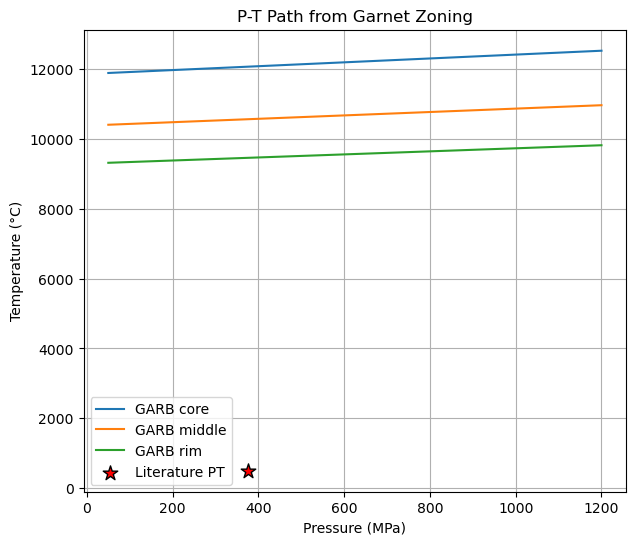

In [36]:
# Plotting
P_grid = np.linspace(50, 1200, 2000)  # MPa
colors = {'core': 'tab:blue', 'middle': 'tab:orange', 'rim': 'tab:green'}

plt.figure(figsize=(7,6))

# GARB curves
for zone in ['core', 'middle', 'rim']:
    
    K = K_garb[zone]    
    
    Tvals_K = np.array([T_from_GARB(K, P) for P in P_grid])
    mask = np.isfinite(Tvals_K)
    
    plt.plot(
        P_grid[mask],
        Tvals_K[mask] - 273.15,   # convert to °C
        label=f'GARB {zone}',
        color=colors[zone]
    )

# GASP intersections
PT_points = {}
for z in ['core','middle','rim']:
    
    Kg = K_garb[z]       
    Kp = K_gasp[z]       
    
    if np.isnan(Kg) or np.isnan(Kp):
        PT_points[z] = (np.nan, np.nan)
        continue
    
    gvals = []
    for P in P_grid:
        T_K = T_from_GARB(Kg, P)
        if not np.isfinite(T_K):
            gvals.append(np.nan)
            continue
        Pcalc = P_from_GASP(Kp, T_K)
        gvals.append(Pcalc - P)
    
    gvals = np.array(gvals)
    
    finite = np.isfinite(gvals)
    if not finite.any():
        PT_points[z] = (np.nan, np.nan)
        continue
    
    idx = np.nanargmin(abs(gvals))
    P_root = P_grid[idx]
    T_root = T_from_GARB(Kg, P_root)
    
    if abs(gvals[idx]) > 5.0:
        PT_points[z] = (np.nan, np.nan)
    else:
        PT_points[z] = (P_root, T_root)

# Plot the intersection
for z,(Psol,Tsol) in PT_points.items():
    if np.isfinite(Psol) and np.isfinite(Tsol):
        plt.scatter(Psol, Tsol - 273.15, s=80, color=colors[z], edgecolor='k', zorder=5)
        plt.text(Psol * 1.01, Tsol - 273.15 + 5, z)

# Literature point
plt.scatter([376], [500], marker='*', s=120, color='red', label='Literature PT', zorder=5, edgecolor='k')

plt.xlabel("Pressure (MPa)")
plt.ylabel("Temperature (°C)")
plt.title("P-T Path from Garnet Zoning")
plt.legend()
plt.grid(True)
plt.show()


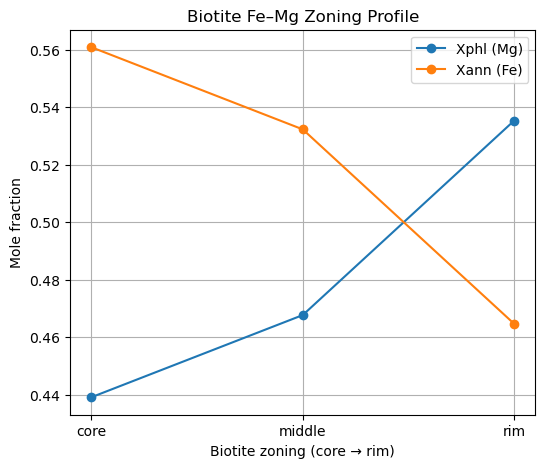

In [37]:
zones = ['core', 'middle', 'rim']
Xphl = [biotite_X[z]['Xphl'] for z in zones]
Xann = [biotite_X[z]['Xann'] for z in zones]

# convert zones to distances (simple indexing)
x = np.arange(len(zones))  # [0,1,2]

plt.figure(figsize=(6,5))
plt.plot(x, Xphl, marker='o', label='Xphl (Mg)')
plt.plot(x, Xann, marker='o', label='Xann (Fe)')

plt.xticks(x, zones)
plt.xlabel("Biotite zoning (core → rim)")
plt.ylabel("Mole fraction")
plt.title("Biotite Fe–Mg Zoning Profile")
plt.legend()
plt.grid(True)
plt.show()

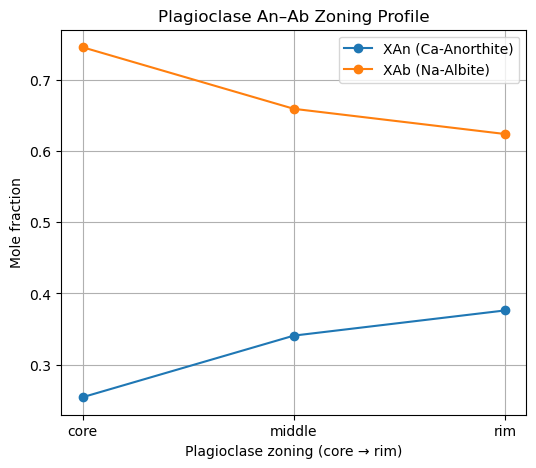

In [38]:
zones = ['core', 'middle', 'rim']

XAn = [plag_X[z]['XAn'] for z in zones]
XAb = [plag_X[z]['XAb'] for z in zones]

x = np.arange(len(zones))

plt.figure(figsize=(6,5))
plt.plot(x, XAn, marker='o', label='XAn (Ca-Anorthite)')
plt.plot(x, XAb, marker='o', label='XAb (Na-Albite)')

plt.xticks(x, zones)
plt.xlabel("Plagioclase zoning (core → rim)")
plt.ylabel("Mole fraction")
plt.title("Plagioclase An–Ab Zoning Profile")
plt.legend()
plt.grid(True)
plt.show()

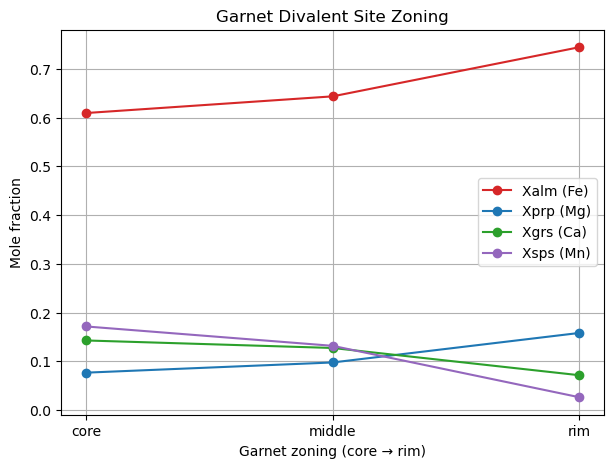

In [39]:
zones = ['core', 'middle', 'rim']

Xalm = [garnet_X[z]['Xalm'] for z in zones]
Xprp = [garnet_X[z]['Xprp'] for z in zones]
Xgrs = [garnet_X[z]['Xgrs'] for z in zones]
Xsps = [garnet_X[z]['Xsps'] for z in zones]

x = np.arange(len(zones))

plt.figure(figsize=(7,5))

plt.plot(x, Xalm, marker='o', label='Xalm (Fe)', color='tab:red')
plt.plot(x, Xprp, marker='o', label='Xprp (Mg)', color='tab:blue')
plt.plot(x, Xgrs, marker='o', label='Xgrs (Ca)', color='tab:green')
plt.plot(x, Xsps, marker='o', label='Xsps (Mn)', color='tab:purple')

plt.xticks(x, zones)
plt.xlabel("Garnet zoning (core → rim)")
plt.ylabel("Mole fraction")
plt.title("Garnet Divalent Site Zoning")
plt.legend()
plt.grid(True)
plt.show()